In [57]:
import os
import pandas as pd

PATH_TO_DATASET = 'MLPC2025_dataset'

annotations = pd.read_csv(os.path.join(PATH_TO_DATASET, "annotations.csv"))

In [8]:
# Count unique annotators per file
annotator_counts = annotations.groupby("filename")["annotator"].nunique().reset_index()

# Filter filenames with more than one annotator
multi_annotated_files = annotator_counts[annotator_counts["annotator"] > 1]["filename"]

# Filter the original dataframe to keep only those files
multiple_annotations = annotations[annotations["filename"].isin(multi_annotated_files)]

# Optional: look at a sample
multiple_annotations.head()

,task_id,filename,annotator,text,onset,offset,filename_unsafe
7,161977606,329549.mp3,7730311164966960713783008629945271263745821651...,A click sound.,5.070086,5.231041,329549_Canarian_Bird_In_Cage_Singing_1wav.mp3
12,161988282,666579.mp3,7677568323544261764859631231436542107544499365...,Claves being played loudly once;,0.091178,0.237062,666579_A veces armo cosas in D major.mp3
14,161981885,482014.mp3,8255123528430973965396800834481421031191605866...,tropical birds chirp and the sound of the sea ...,13.187639,17.789174,482014_0515_birds and beach_1015WAV.mp3
19,161984978,624495.mp3,7305489040855023434029597881305170467636785003...,Woman is laughing,0.000000,1.098097,624495_kamala laugh slow verbaif.mp3
25,161980213,221499.mp3,2511836030875594054249018396648810123064624225...,Heavy rain falling on wooden surface,0.000000,28.665805,221499_heavy rain on wooden doorsWAV.mp3


In [9]:
import numpy as np
import pandas as pd

def compute_iou(a_start, a_end, b_start, b_end):
    inter_start = max(a_start, b_start)
    inter_end = min(a_end, b_end)
    intersection = max(0, inter_end - inter_start)
    union = max(a_end, b_end) - min(a_start, b_start)
    return intersection / union if union > 0 else 0

# Set IoU threshold to consider annotations as referring to the same event
IOU_THRESHOLD = 0.5

results = []

for filename in multi_annotated_files:
    file_anns = multiple_annotations[multiple_annotations["filename"] == filename]
    
    # Sort for consistency
    file_anns = file_anns.sort_values(by="onset")
    
    # Group matching annotations into "event clusters"
    clusters = []
    used = set()
    
    for i, row in file_anns.iterrows():
        if i in used:
            continue
        
        # Start new cluster
        cluster = [row]
        used.add(i)
        
        for j, other in file_anns.iterrows():
            if j in used or row["annotator"] == other["annotator"]:
                continue
            
            iou = compute_iou(row["onset"], row["offset"], other["onset"], other["offset"])
            if iou >= IOU_THRESHOLD:
                cluster.append(other)
                used.add(j)
        
        if len(cluster) > 1:  # Only consider clusters with >1 annotator
            clusters.append(pd.DataFrame(cluster))

    # Compute MADs for each cluster
    cluster_mads = []
    for cluster_df in clusters:
        onset_mad = np.mean(np.abs(cluster_df["onset"] - cluster_df["onset"].mean()))
        offset_mad = np.mean(np.abs(cluster_df["offset"] - cluster_df["offset"].mean()))
        cluster_mads.append((onset_mad, offset_mad))

    if cluster_mads:
        onset_mad_avg = np.mean([m[0] for m in cluster_mads])
        offset_mad_avg = np.mean([m[1] for m in cluster_mads])
    else:
        onset_mad_avg = np.nan
        offset_mad_avg = np.nan

    results.append({
        "filename": filename,
        "num_clusters": len(clusters),
        "onset_MAD": onset_mad_avg,
        "offset_MAD": offset_mad_avg,
        "num_annotations": len(file_anns)
    })

mad_df = pd.DataFrame(results)
mad_df.head()


,filename,num_clusters,onset_MAD,offset_MAD,num_annotations
0,104625.mp3,13,0.071570,0.053978,32
1,106035.mp3,1,0.012258,0.000000,2
2,108514.mp3,1,0.014656,0.000000,2
3,113327.mp3,1,2.364818,2.075012,6
4,113340.mp3,0,NaN,NaN,2


In [10]:
weighted_onset_precision = (
    (mad_df["onset_MAD"] * mad_df["num_clusters"]).sum() / mad_df["num_clusters"].sum()
)

weighted_offset_precision = (
    (mad_df["offset_MAD"] * mad_df["num_clusters"]).sum() / mad_df["num_clusters"].sum()
)

print(f"Weighted Onset MAD: {weighted_onset_precision:.3f} seconds")
print(f"Weighted Offset MAD: {weighted_offset_precision:.3f} seconds")

# Normalize to a [0,1] scale where 1 = perfect alignment, 0 = very off
score = lambda mad: max(0, 1 - mad)  # simple linear decay

onset_precision_score = score(weighted_onset_precision)
offset_precision_score = score(weighted_offset_precision)

print(f"Overall Temporal Precision Score (Onset): {onset_precision_score:.2f}")
print(f"Overall Temporal Precision Score (Offset): {offset_precision_score:.2f}")


Weighted Onset MAD: 0.202 seconds
Weighted Offset MAD: 0.226 seconds
Overall Temporal Precision Score (Onset): 0.80
Overall Temporal Precision Score (Offset): 0.77


C:\Users\TET\AppData\Local\Temp\ipykernel_17092\2424431319.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=labels, patch_artist=True, widths=0.4,


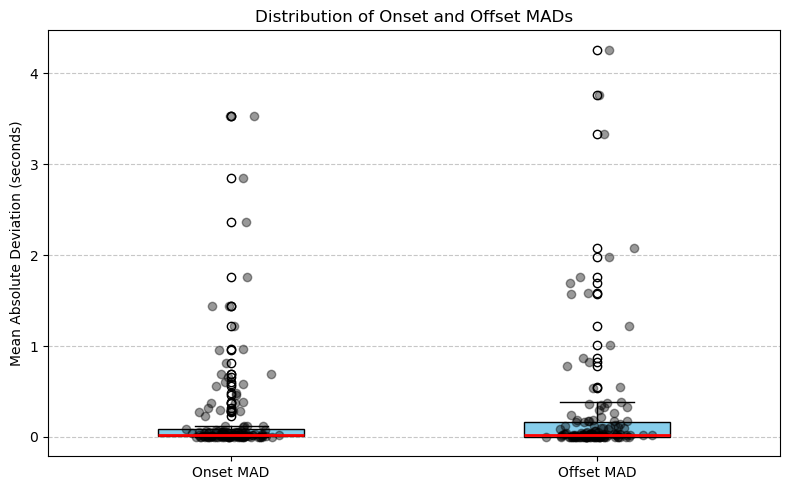

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
onset_mads = mad_df["onset_MAD"].dropna().values
offset_mads = mad_df["offset_MAD"].dropna().values

data = [onset_mads, offset_mads]
labels = ["Onset MAD", "Offset MAD"]

# Plot
plt.figure(figsize=(8, 5))

# Boxplot
bp = plt.boxplot(data, labels=labels, patch_artist=True, widths=0.4,
                 boxprops=dict(facecolor="skyblue"),
                 medianprops=dict(color="red", linewidth=2))

# Scatter points (jittered)
for i, group in enumerate(data):
    x = np.random.normal(i + 1, 0.05, size=len(group))  # jitter
    plt.plot(x, group, 'o', color='black', alpha=0.4)

# Labels and title
plt.title("Distribution of Onset and Offset MADs")
plt.ylabel("Mean Absolute Deviation (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [71]:
import os
import numpy as np
import pandas as pd
import re

# Load metadata
metadata = pd.read_csv(os.path.join(PATH_TO_DATASET, "metadata.csv"))

# --- Helper Functions ---

def iou(a, b):
    inter_start = max(a["onset"], b["onset"])
    inter_end = min(a["offset"], b["offset"])
    inter = max(0, inter_end - inter_start)
    union = max(a["offset"], b["offset"]) - min(a["onset"], b["onset"])
    return inter / union if union > 0 else 0

def cluster_annotations(df, iou_threshold=0.5):
    used = set()
    clusters = []
    for i, row_i in df.iterrows():
        if i in used:
            continue
        cluster = [i]
        for j, row_j in df.iterrows():
            if j != i and j not in used and iou(row_i, row_j) > iou_threshold:
                cluster.append(j)
        used.update(cluster)
        clusters.append(df.loc[cluster])
    return clusters

def extract_keywords_from_text(text):
    if not isinstance(text, str):
        return set()
    words = re.sub(r"[^\w\s]", "", text.lower()).split()
    return set(words)

def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return np.nan
    return len(set1 & set2) / len(set1 | set2)

def compute_keyword_similarity_from_texts(text_list):
    sets = [extract_keywords_from_text(t) for t in text_list if isinstance(t, str) and t.strip()]
    if len(sets) < 2:
        return np.nan
    sims = [
        jaccard_similarity(sets[i], sets[j])
        for i in range(len(sets)) for j in range(i + 1, len(sets))
    ]
    return np.mean(sims)

# --- Main Processing ---

keyword_similarities = []

for filename in multi_annotated_files:
    file_data = multiple_annotations[multiple_annotations["filename"] == filename]

    clusters = cluster_annotations(file_data, iou_threshold=0.5)
    #print(f"File: {filename}, #Clusters: {len(clusters)}")

    for cluster_df in clusters:
        if len(cluster_df) < 2:
            continue
        text_list = cluster_df["text"].dropna().tolist()
        keyword_sim = compute_keyword_similarity_from_texts(text_list)
        if not np.isnan(keyword_sim):
            keyword_similarities.append(keyword_sim)

# --- Output ---
if keyword_similarities:
    overall_keyword_similarity = np.mean(keyword_similarities)
    print(f"\n Average annotation similarity (based on text): {overall_keyword_similarity:.3f}")
else:
    print("\n No valid annotation similarities found.")



 Average annotation similarity (based on text): 0.135


In [72]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- Helper: compute average cosine similarity between texts ---
def compute_text_similarity(texts):
    if len(texts) < 2:
        return np.nan
    tfidf = TfidfVectorizer().fit_transform(texts)
    sim_matrix = cosine_similarity(tfidf)
    # Upper triangle without diagonal
    sims = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    return np.mean(sims) if len(sims) > 0 else np.nan
text_similarities = []

for filename in multi_annotated_files:
    file_data = multiple_annotations[multiple_annotations["filename"] == filename]
    
    clusters = cluster_annotations(file_data, iou_threshold=0.5)

    for cluster_df in clusters:
        if len(cluster_df) < 2:
            continue
        text_list = cluster_df["text"].dropna().tolist()
        if len(text_list) < 2:
            continue
        sim = compute_text_similarity(text_list)
        if not np.isnan(sim):
            text_similarities.append(sim)

if text_similarities:
    avg_text_sim = np.mean(text_similarities)
    print(f"\nAverage text similarity across clusters: {avg_text_sim:.3f}")
else:
    print("\nNo valid text similarities found.")



Average text similarity across clusters: 0.137


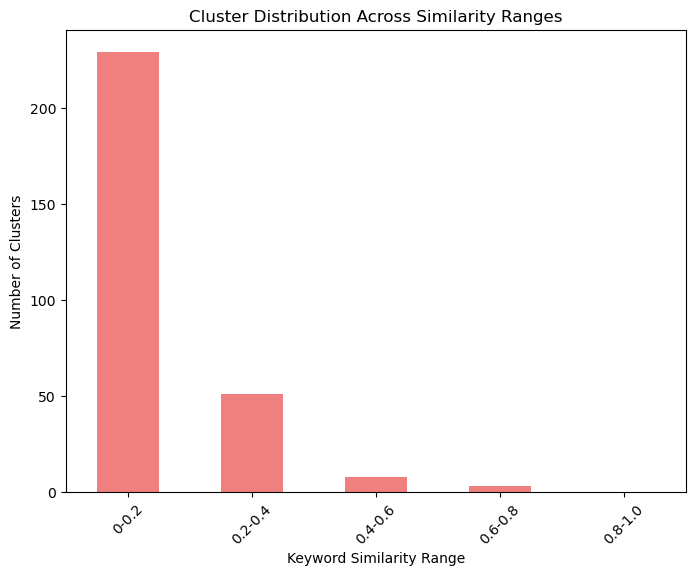

In [73]:
# Create similarity bins for clustering
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

# Classify the keyword similarities into bins
similarity_bins = pd.cut(text_similarities, bins=bins, labels=bin_labels, include_lowest=True)

# Plot a bar chart of the cluster distribution in each similarity bin
plt.figure(figsize=(8, 6))
similarity_bins.value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.title('Cluster Distribution Across Similarity Ranges')
plt.xlabel('Keyword Similarity Range')
plt.ylabel('Number of Clusters')
plt.xticks(rotation=45)
plt.show()


In [74]:
import os
import numpy as np
import pandas as pd
import re

# Load metadata
metadata = pd.read_csv(os.path.join(PATH_TO_DATASET, "metadata.csv"))

# --- Helper Functions ---

def extract_keywords_from_text(text):
    if not isinstance(text, str):
        return set()
    words = re.sub(r"[^\w\s]", "", text.lower()).split()
    return set(words)

def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return np.nan
    return len(set1 & set2) / len(set1 | set2)

def compute_keyword_similarity_from_texts(text_list):
    sets = [extract_keywords_from_text(t) for t in text_list if isinstance(t, str) and t.strip()]
    if len(sets) < 2:
        return np.nan
    sims = [
        jaccard_similarity(sets[i], sets[j])
        for i in range(len(sets)) for j in range(i + 1, len(sets))
    ]
    return np.mean(sims)

# --- Main Processing ---

keyword_similarities = []

for filename in multi_annotated_files:
    file_data = multiple_annotations[multiple_annotations["filename"] == filename]

    # Collect text from all annotations in the file
    text_list = file_data["text"].dropna().tolist()

    # Calculate keyword similarity for the entire file (without clustering)
    keyword_sim = compute_keyword_similarity_from_texts(text_list)

    if not np.isnan(keyword_sim):
        keyword_similarities.append(keyword_sim)

# --- Output ---
if keyword_similarities:
    overall_keyword_similarity = np.mean(keyword_similarities)
    print(f"\n Average annotation similarity (based on text): {overall_keyword_similarity:.3f}")
else:
    print("\n No valid annotation similarities found.")



 Average annotation similarity (based on text): 0.221


In [87]:
import pandas as pd

annotations = pd.read_csv("MLPC2025_dataset/annotations.csv")

# Count of annotations per file
annotations_per_file = annotations.groupby("filename").size().reset_index(name="num_annotations")

# Preview
#print(annotations_per_file.head())
num_annotated_files = annotations["filename"].nunique()
print("Number of annotated files:", num_annotated_files)

print("Average annotations per file:", annotations_per_file["num_annotations"].mean())
print("Median annotations per file:", annotations_per_file["num_annotations"].median())
print("Min annotations in a file:", annotations_per_file["num_annotations"].min())
print("Max annotations in a file:", annotations_per_file["num_annotations"].max())


Number of annotated files: 2000
Average annotations per file: 3.9875
Median annotations per file: 2.0
Min annotations in a file: 1
Max annotations in a file: 73


In [86]:
import pandas as pd
import re

# Load metadata
metadata = pd.read_csv("MLPC2025_dataset/metadata.csv")

# --- Helper: Clean and tokenize keywords ---
def clean_and_tokenize_keywords(keywords):
    if not isinstance(keywords, str):
        return set()
    # Remove punctuation, lowercase, split on comma or space
    keywords = re.sub(r"[^\w\s,]", "", keywords.lower())
    tokens = re.split(r"[,\s]+", keywords)
    return set(token.strip() for token in tokens if token.strip())

# --- Main processing ---
sound_sources_per_file = []

for filename, group in metadata.groupby("filename"):
    all_keywords = set()
    for kw in group["keywords"].dropna():
        all_keywords.update(clean_and_tokenize_keywords(kw))
    
    sound_sources_per_file.append({
        "filename": filename,
        "estimated_sound_sources": len(all_keywords),
        "unique_keywords": all_keywords
    })

sources_df = pd.DataFrame(sound_sources_per_file)

# --- Output ---
print(sources_df[["filename", "estimated_sound_sources"]].head())
print(f"\nAverage estimated sound sources per file (metadata): {sources_df['estimated_sound_sources'].mean():.2f}")


     filename  estimated_sound_sources
0  100388.mp3                       12
1  100492.mp3                        5
2  101693.mp3                        4
3  103192.mp3                        9
4  104625.mp3                       10

Average estimated sound sources per file (metadata): 10.43


In [90]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import re

# Load data
annotations = pd.read_csv("MLPC2025_dataset/annotations.csv")
annotations = annotations.dropna(subset=["text"])

# --- Simple text metrics ---
def simple_metrics(text):
    words = re.findall(r'\b\w+\b', text.lower())
    word_count = len(words)
    char_count = len(text)
    return word_count, char_count

annotations[["word_count", "char_count"]] = annotations["text"].apply(lambda t: pd.Series(simple_metrics(t)))

# Vocabulary size per annotator
def get_vocab(texts):
    vocab = set()
    for text in texts.dropna():
        words = re.findall(r'\b\w+\b', text.lower())
        vocab.update(words)
    return vocab

annotator_stats = annotations.groupby("annotator").agg({
    "word_count": ["mean", "std"],
    "char_count": "mean",
    "text": lambda x: len(get_vocab(x))
}).reset_index()

annotator_stats.columns = ["annotator", "avg_word_count", "word_count_std", "avg_char_count", "vocab_size"]


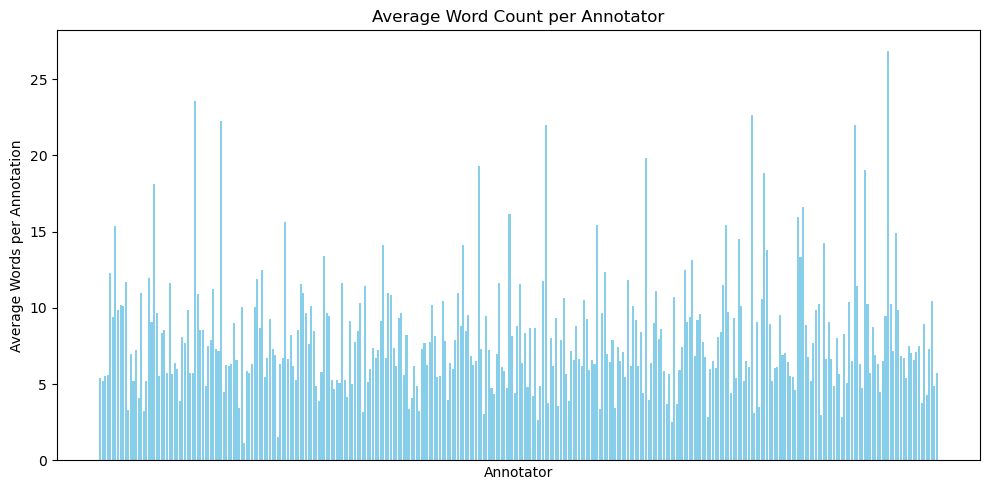

In [93]:
import matplotlib.pyplot as plt

# Plot average word count per annotator
plt.figure(figsize=(10, 5))
plt.bar(annotator_stats["annotator"], annotator_stats["avg_word_count"], color='skyblue')
plt.title("Average Word Count per Annotator")
plt.xlabel("Annotator")
plt.ylabel("Average Words per Annotation")
plt.xticks([])
plt.tight_layout()
plt.show()


In [94]:
# Calculate average word count for all annotations
average_word_count_all_annotations = annotations["word_count"].mean()

# Print the result
print(f"Average Word Count of All Annotations: {average_word_count_all_annotations:.2f}")


Average Word Count of All Annotations: 7.58


In [95]:
# Count annotations with 2 or fewer words
annotations_with_2_or_less_words = annotations[annotations["word_count"] <= 2]

# Get the count of such annotations
count_annotations_with_2_or_less_words = annotations_with_2_or_less_words.shape[0]

# Print the result
print(f"Number of annotations with 2 or fewer words: {count_annotations_with_2_or_less_words}")


Number of annotations with 2 or fewer words: 509


In [96]:
# Group annotations by annotator and calculate the average word count for each annotator
average_word_count_per_annotator = annotations.groupby("annotator")["word_count"].mean()

# Count how many annotators have an average word count of less than 3
annotators_with_less_than_3_words = (average_word_count_per_annotator < 3).sum()

# Print the result
print(f"Number of annotators who, on average, annotate with less than 3 words: {annotators_with_less_than_3_words}")


Number of annotators who, on average, annotate with less than 3 words: 6


In [97]:
# Group annotations by annotator and calculate the average word count for each annotator
average_word_count_per_annotator = annotations.groupby("annotator")["word_count"].mean()

# Count how many annotators have an average word count of less than 3
annotators_with_less_than_3_words = (average_word_count_per_annotator < 4).sum()

# Print the result
print(f"Number of annotators who, on average, annotate with less than 3 words: {annotators_with_less_than_3_words}")


Number of annotators who, on average, annotate with less than 3 words: 28


In [98]:
# Get total number of unique annotators
total_annotators = annotations["annotator"].nunique()

# Print the result
print(f"Total number of annotators: {total_annotators}")


Total number of annotators: 326


In [101]:
# Count the number of annotations with 2 or fewer words
num_short_annotations = (annotations["word_count"] <= 1).sum()

# Print the result
print(f"Number of annotations with 1 or fewer words: {num_short_annotations}")


Number of annotations with 1 or fewer words: 59


In [102]:
# Count the number of annotations with 2 or fewer words
num_short_annotations = (annotations["word_count"] <= 2).sum()

# Print the result
print(f"Number of annotations with 2 or fewer words: {num_short_annotations}")


Number of annotations with 2 or fewer words: 509
